In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import shapiro, kurtosis
import os

In [66]:
# Load your data
data = pd.read_csv('output.csv')
print(data)

      3  4
0     4  3
1    12  3
2    22  3
3    10  1
4     8  1
..   .. ..
359  11  1
360   2  1
361   1  1
362   6  1
363   4  1

[364 rows x 2 columns]


In [21]:
model = 'M2'
theta_folder = f"Real data/theta_hat_RD_{model}_results.csv"
theta = pd.read_csv(theta_folder, header=None)
print(theta)

                  0                  1                  2                  3  \
0            omega1            alpha11             beta11             omega2   
1  3.63271670716456  0.374455618058163  0.127830627256454  0.872498309355207   

                   4                  5                 6                  7  \
0            alpha22             beta21             delta      LogLikelihood   
1  0.324438579064818  0.101616946516453  1.71640648616489  -1742.41195451768   

                  8                 9  
0               AIC               BIC  
1  3498.82390903536  3526.12319051044  


In [22]:
# Extract values from omega1 to delta
values = theta.iloc[1, :6].tolist()  # Adjust the column index range as needed

print(values)

['3.63271670716456', '0.374455618058163', '0.127830627256454', '0.872498309355207', '0.324438579064818', '0.101616946516453']


In [23]:
omega1 = float(theta.iloc[1,0])
omega2 = float(theta.iloc[1,3])
omega = [omega1, omega2]
print(omega)

[3.63271670716456, 0.872498309355207]


In [24]:
# Extract specific values for the matrix
alpha11 = float(theta.iloc[1, 1])
alpha12 = 0
alpha21 = 0
alpha22 = float(theta.iloc[1, 4])
# Create the 2x2 matrix
A = [[alpha11, alpha12], [alpha21, alpha22]]
print(A)

[[0.374455618058163, 0], [0, 0.324438579064818]]


In [25]:
beta11 = float(theta.iloc[1, 2])
beta12 = 0
beta21 = 0
beta22 = float(theta.iloc[1, 5])
# Create the 2x2 matrix
B = [[beta11, beta12], [beta21, beta22]]
print(B)

[[0.127830627256454, 0], [0, 0.101616946516453]]


In [26]:
delta = float(theta.iloc[1,6])
print(delta)

1.71640648616489


In [27]:
def compute_lambda_t(theta, data):
    omega1 = float(theta[0])
    alpha11 = float(theta[1])
    beta11 = float(theta[2])
    omega2 = float(theta[3])
    alpha22 = float(theta[4])
    beta22 = float(theta[5])
    # Initialize lambda_t
    T = len(data)

    # Initialize lambda values with the first data point
    lambda1 = np.zeros(T)
    lambda2 = np.zeros(T)
    lambda1[0] = data.iloc[0, 0]
    lambda2[0] = data.iloc[1, 1]

    # Compute lambda_t series
    for t in range(1, T):
        lambda1[t] = (omega1 + alpha11 * lambda1[t-1] + beta11 * data.iloc[t-1, 0] )
        lambda2[t] = (omega2 + alpha22 * lambda2[t-1] + beta22 * data.iloc[t-1, 1])

    return lambda1, lambda2


In [28]:
def BPdist(lam1, lam2, delt):
    c = 1 - np.e**(-1)
    val_lim = 50
    #initialisation de la premiere var poisson et var unif
    Y1 = np.random.poisson(lam=lam1, size=1)[0]  # Extract scalar value from array
    u = np.random.uniform(0, 1)
    #fonction de masse
    P = np.zeros(val_lim+1)
    for i in range(val_lim+1):  # Adjust range to include val_lim
        P[i] = (lam2**i / (np.math.factorial(i))) * np.e**(-lam2) * (1 + delt * (np.e**(-Y1) - np.e**(-c*lam1)) * (np.e**(-i) - np.e**(-c*lam2)))
    #fonction de mass cumulée
    Pcum = np.zeros(val_lim+1)
    Pcum[0] = P[0]
    for i in range(1, val_lim+1):
        Pcum[i] = P[i] + Pcum[i-1]
    
    found = False
    i = 0
    while not found and i < val_lim:
        if u < Pcum[i]: 
            found = True
        else:
            i += 1

    Y2 = np.array([i])
    Y = np.zeros((2, 1))
    Y[0, 0] = Y1
    Y[1, 0] = Y2
    return Y


In [29]:
def BPsmodel( n, delt, lambda1, lambda2):
    Y = np.zeros((2,n))
    for i in range(1,n):
        yint = BPdist(lambda1[i], lambda2[i], delt)
        Y[0,i] = yint[0]
        Y[1,i] = yint[1]
    return np.transpose(Y)

In [30]:
# Compute lambda1 and lambda2 once
lambda1, lambda2 = compute_lambda_t(values, data)

# Generate the model output
y_hat = BPsmodel(len(data), delta, lambda1, lambda2)
print(y_hat)

C:\Users\HW\AppData\Local\Temp\ipykernel_2004\3411593700.py:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  P[i] = (lam2**i / (np.math.factorial(i))) * np.e**(-lam2) * (1 + delt * (np.e**(-Y1) - np.e**(-c*lam1)) * (np.e**(-i) - np.e**(-c*lam2)))
C:\Users\HW\AppData\Local\Temp\ipykernel_2004\3411593700.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[1, 0] = Y2
C:\Users\HW\AppData\Local\Temp\ipykernel_2004\1573662757.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y[0,i] = yint[0]
C:\Users\HW\AppData\Local\Temp\ipyker

[[ 0.  0.]
 [ 8.  2.]
 [ 9.  1.]
 [12.  4.]
 [ 6.  0.]
 [14.  1.]
 [11.  0.]
 [ 6.  3.]
 [ 4.  3.]
 [ 6.  1.]
 [14.  2.]
 [ 4.  0.]
 [ 5.  3.]
 [ 5.  1.]
 [ 6.  1.]
 [11.  3.]
 [ 8.  0.]
 [ 5.  0.]
 [ 4.  2.]
 [ 4.  2.]
 [10.  3.]
 [ 9.  0.]
 [ 9.  1.]
 [ 9.  0.]
 [ 5.  2.]
 [ 9.  1.]
 [ 5.  4.]
 [ 7.  1.]
 [ 7.  2.]
 [ 9.  3.]
 [10.  0.]
 [ 3.  2.]
 [ 9.  2.]
 [ 3.  1.]
 [ 7.  1.]
 [ 8.  1.]
 [ 8.  0.]
 [10.  0.]
 [ 8.  5.]
 [ 9.  1.]
 [13.  1.]
 [ 7.  5.]
 [ 8.  1.]
 [12.  3.]
 [ 4.  2.]
 [ 8.  2.]
 [ 8.  1.]
 [ 9.  4.]
 [ 8.  3.]
 [ 7.  3.]
 [ 5.  1.]
 [ 6.  0.]
 [ 6.  0.]
 [ 6.  2.]
 [ 8.  1.]
 [ 8.  1.]
 [10.  0.]
 [10.  1.]
 [ 8.  1.]
 [11.  1.]
 [ 4.  1.]
 [10.  2.]
 [ 5.  1.]
 [ 7.  0.]
 [ 9.  2.]
 [14.  0.]
 [ 4.  1.]
 [ 5.  3.]
 [ 7.  1.]
 [ 9.  1.]
 [ 6.  1.]
 [ 9.  1.]
 [ 6.  3.]
 [ 6.  1.]
 [11.  0.]
 [11.  1.]
 [11.  3.]
 [ 9.  2.]
 [ 6.  1.]
 [ 3.  2.]
 [13.  1.]
 [10.  1.]
 [12.  2.]
 [ 6.  3.]
 [ 5.  2.]
 [ 2.  0.]
 [ 9.  2.]
 [ 6.  2.]
 [ 7.  0.]
 [ 7.  0.]
 [10.  1.]

In [31]:
# Save y_hat to a CSV file
y_hat_df = pd.DataFrame(y_hat, columns=['Y1', 'Y2'])  # Transpose to get columns for Y1 and Y2
y_hat_df.to_csv('y_hat_results_M2.csv', index=False)

In [32]:
y_hat= pd.read_csv('y_hat_results_M2.csv', header=None, skiprows=1)
print(y_hat)

        0    1
0     0.0  0.0
1     8.0  2.0
2     9.0  1.0
3    12.0  4.0
4     6.0  0.0
..    ...  ...
359   7.0  1.0
360   6.0  2.0
361   6.0  2.0
362   3.0  2.0
363   4.0  1.0

[364 rows x 2 columns]


In [73]:
# Reload y_hat to ensure it's in the correct format
y_hat = pd.read_csv('Real data/y_hat_results_M1.csv', header=None, skiprows=1)
# Calculate the residuals
n = len(data)
res = np.zeros((n, 2))
for i in range(n):
    res[i, 0] = data.iloc[i, 0] - y_hat.iloc[i, 0]
    res[i, 1] = data.iloc[i, 1] - y_hat.iloc[i, 1]
print(res)


[[  4.   3.]
 [ -2.   1.]
 [ 14.   2.]
 [  1.  -4.]
 [ -1.  -1.]
 [ -3.   0.]
 [  8.  -1.]
 [  3.   0.]
 [  5.  -1.]
 [  0.   1.]
 [ -5.  -3.]
 [ -6.   1.]
 [ -1.   2.]
 [  7.   1.]
 [ -2.  -1.]
 [ -6.   1.]
 [  1.   1.]
 [ -4.   1.]
 [ -3.   0.]
 [  9.  -1.]
 [ -1.  -1.]
 [ -2.  -1.]
 [  9.   1.]
 [  2.   0.]
 [  1.  -1.]
 [ -3.   3.]
 [  0.  -1.]
 [  1.   0.]
 [  0.   0.]
 [ -1.  -3.]
 [  1.   2.]
 [ -6.   0.]
 [ -3.  -2.]
 [  4.   1.]
 [  8.   0.]
 [  1.   0.]
 [ -1.   2.]
 [ 11.   4.]
 [  0.   2.]
 [  2.   1.]
 [  9.   0.]
 [ -6.  -2.]
 [ -2.  -1.]
 [  2.  -2.]
 [  2.  -2.]
 [-10.  -1.]
 [ -2.   0.]
 [  2.   1.]
 [ -7.   5.]
 [  1.   2.]
 [ -3.  -2.]
 [  0.  -3.]
 [ -3.  -1.]
 [  8.   1.]
 [  9.   2.]
 [  7.   0.]
 [ -1.   1.]
 [  2.  -2.]
 [ -1.   0.]
 [ -6.   1.]
 [ -6.   2.]
 [ -4.   0.]
 [ -4.  -1.]
 [  9.   1.]
 [  3.   2.]
 [  0.   0.]
 [  0.   1.]
 [ -4.   2.]
 [ -5.  -5.]
 [ -1.   2.]
 [ -6.   0.]
 [  2.   3.]
 [  1.   0.]
 [ -1.  -2.]
 [  1.   0.]
 [  2.   2.]
 [ -2.  -3.]

In [74]:
# Save y_hat to a CSV file
res_df = pd.DataFrame(res, columns=['res1', 'res2'])  # Transpose to get columns for Y1 and Y2
res_df.to_csv('res_results_M1.csv', index=False)

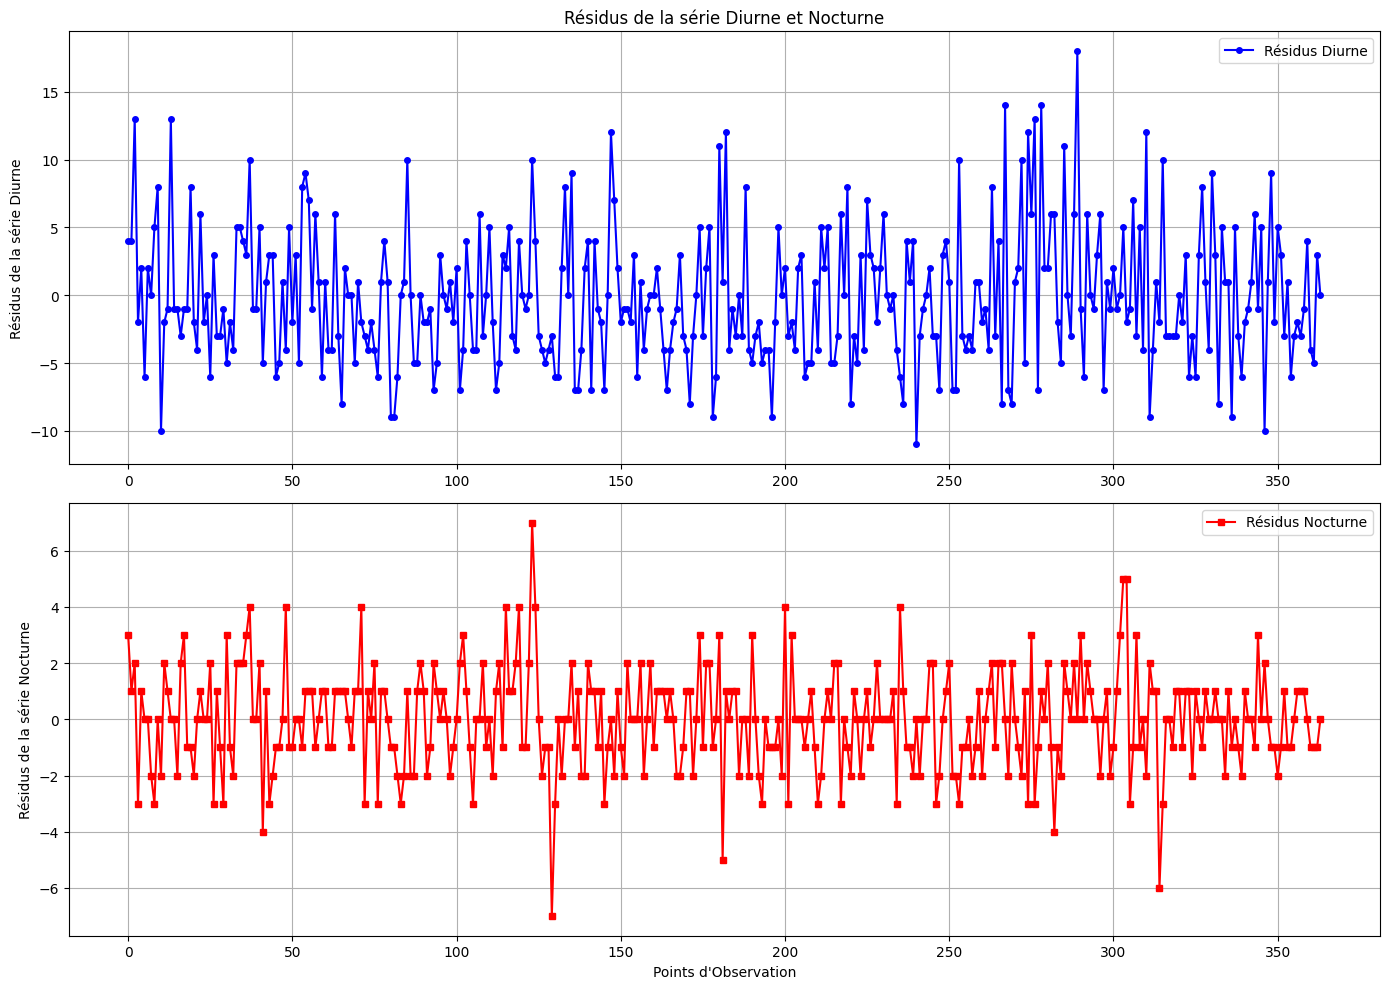

In [35]:
# Plot the residuals
plt.figure(figsize=(14, 10))

# Plot residuals for Variable1
plt.subplot(2, 1, 1)
plt.plot(range(n), res[:, 0], label='Résidus Diurne', marker='o', linestyle='-', color='b', markersize=4)
plt.title('Résidus de la série Diurne et Nocturne')
plt.ylabel('Résidus de la série Diurne')
plt.legend()
plt.grid(True)

# Plot residuals for Variable2
plt.subplot(2, 1, 2)
plt.plot(range(n), res[:, 1], label='Résidus Nocturne', marker='s', linestyle='-', color='r', markersize=4)
plt.xlabel('Points d\'Observation')
plt.ylabel('Résidus de la série Nocturne')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

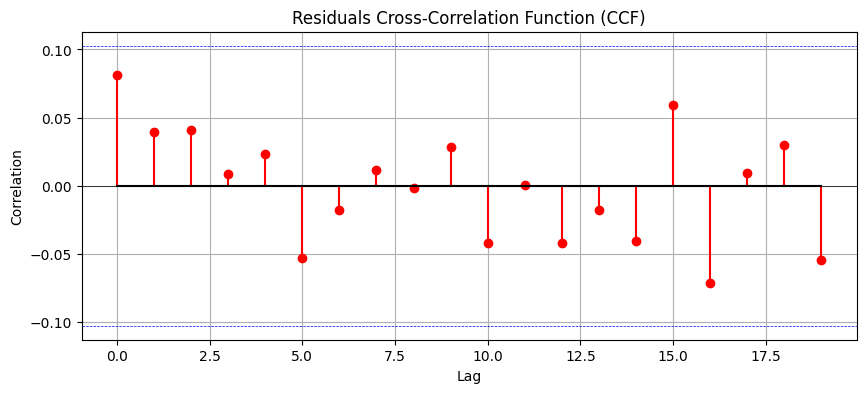

In [36]:
# Calculate the CCF values
ccf_values = ccf(res[:,0], res[:,1], adjusted=False)

# Define the number of lags to plot
num_lags = 20
lags = np.arange(num_lags)

# Calculate confidence intervals
conf_interval = 1.96 / np.sqrt(len(res))

# Plot the CCF with confidence intervals
plt.figure(figsize=(10, 4))
plt.stem(lags, ccf_values[:num_lags], linefmt='r-', markerfmt='ro', basefmt='k-')
plt.axhline(y=conf_interval, linestyle='--', color='blue', linewidth=0.5)
plt.axhline(y=-conf_interval, linestyle='--', color='blue', linewidth=0.5)
plt.axhline(y=0, linestyle='-', color='black', linewidth=0.5)
plt.title('Residuals Cross-Correlation Function (CCF)')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

In [37]:
def plot_acf_pacf(data, title, ax_acf, ax_pacf, lags=20):
    # Calculate ACF and PACF values
    acf_vals = acf(data, nlags=lags)
    pacf_vals = pacf(data, nlags=lags)
    
    # Plot ACF
    ax_acf.stem(range(len(acf_vals)), acf_vals, linefmt='r-', markerfmt='ro', basefmt='k-')
    ax_acf.axhline(y=0, linestyle='-', color='black')
    ax_acf.axhline(y=1.96/len(data)**0.5, linestyle='--', color='blue')
    ax_acf.axhline(y=-1.96/len(data)**0.5, linestyle='--', color='blue')
    ax_acf.set_title(f'ACF for {title}')
    ax_acf.set_xlabel('Lag')
    ax_acf.set_ylabel('ACF')
    
    # Plot PACF
    ax_pacf.stem(range(len(pacf_vals)), pacf_vals, linefmt='r-', markerfmt='ro', basefmt='k-')
    ax_pacf.axhline(y=0, linestyle='-', color='black')
    ax_pacf.axhline(y=1.96/len(data)**0.5, linestyle='--', color='blue')
    ax_pacf.axhline(y=-1.96/len(data)**0.5, linestyle='--', color='blue')
    ax_pacf.set_title(f'PACF for {title}')
    ax_pacf.set_xlabel('Lag')
    ax_pacf.set_ylabel('PACF')

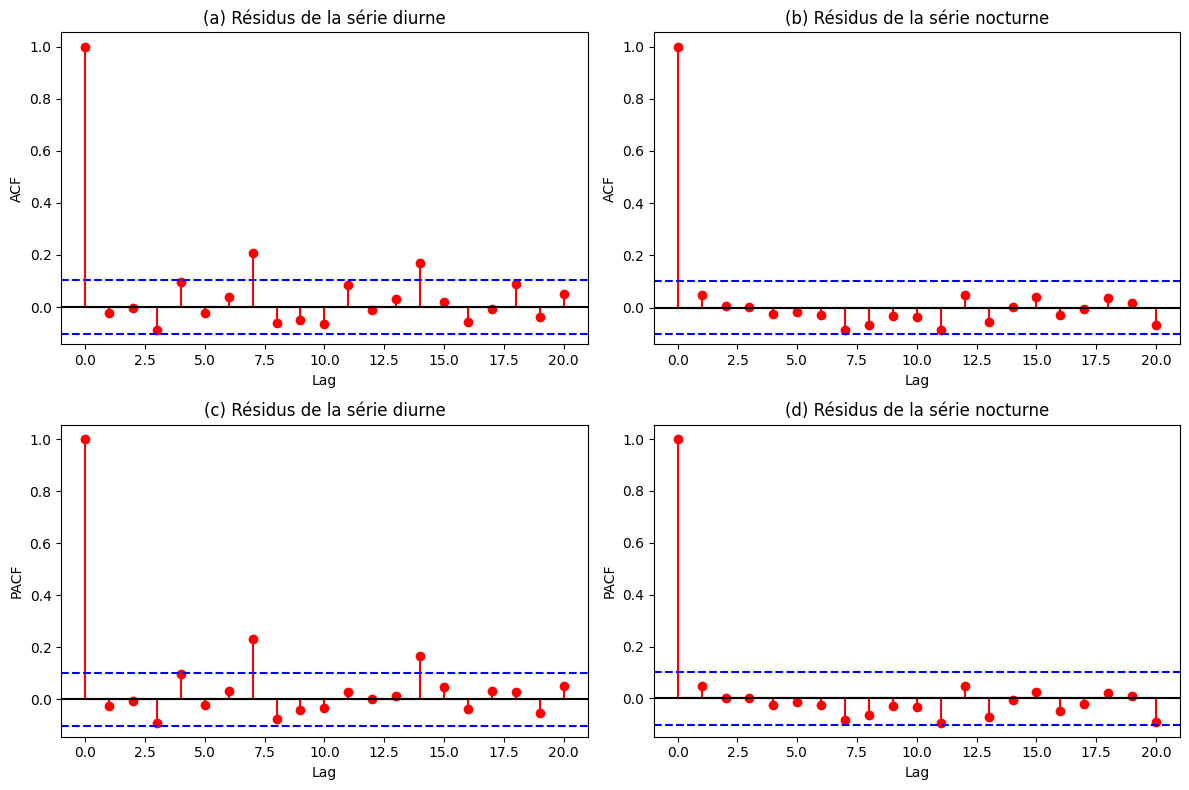

In [38]:
# Plot the ACF and PACF for Variable1 and Variable2
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# ACF and PACF for Variable1
plot_acf_pacf(res[:,0], 'Résidus de la série diurne', ax[0, 0], ax[1, 0], lags=20)
ax[0, 0].set_title('(a) Résidus de la série diurne')
ax[1, 0].set_title('(c) Résidus de la série diurne')

# ACF and PACF for Variable2
plot_acf_pacf(res[:,1], 'Résidus de la série nocturne', ax[0, 1], ax[1, 1], lags=20)
ax[0, 1].set_title('(b) Résidus de la série nocturne')
ax[1, 1].set_title('(d) Résidus de la série nocturne')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [40]:
mean_res = res.mean(axis=0)
print(mean_res)

[-0.20604396 -0.02747253]


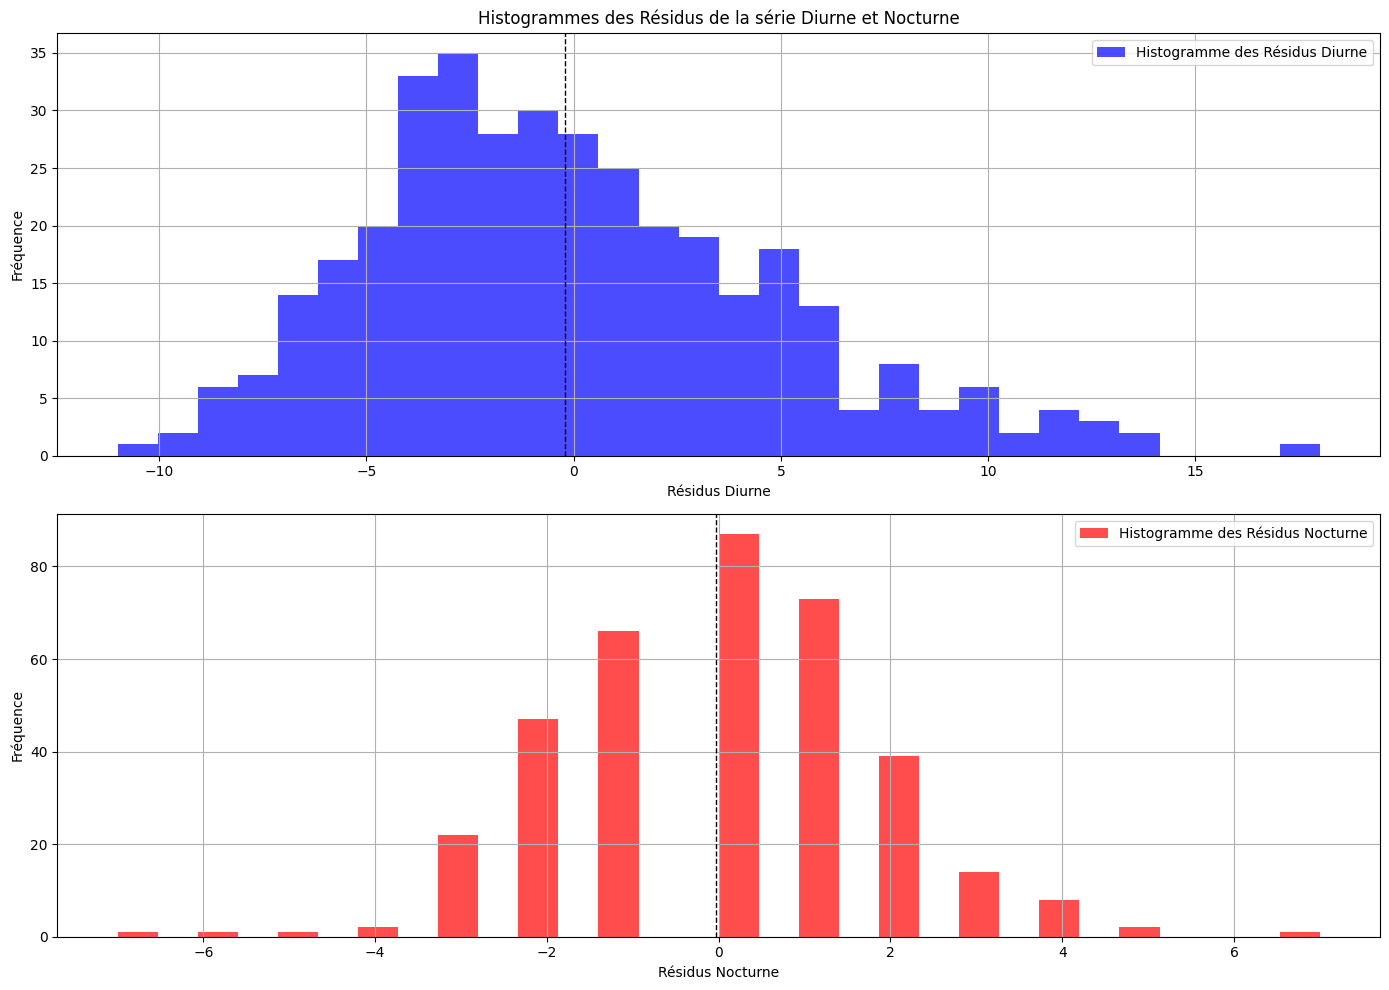

In [39]:
# Plot histograms of the residuals
plt.figure(figsize=(14, 10))

# Histogram for residuals of Variable1
plt.subplot(2, 1, 1)
plt.hist(res[:, 0], bins=30, color='b', alpha=0.7, label='Histogramme des Résidus Diurne')
plt.axvline(res[:, 0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.title('Histogrammes des Résidus de la série Diurne et Nocturne')
plt.xlabel('Résidus Diurne')
plt.ylabel('Fréquence')
plt.legend()
plt.grid(True)

# Histogram for residuals of Variable2
plt.subplot(2, 1, 2)
plt.hist(res[:, 1], bins=30, color='r', alpha=0.7, label='Histogramme des Résidus Nocturne')
plt.axvline(res[:, 1].mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Résidus Nocturne')
plt.ylabel('Fréquence')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [41]:
# Apply the Shapiro-Wilk test for normality
stat1, p1 = shapiro(res[:, 0])
stat2, p2 = shapiro(res[:, 1])

print(f'Shapiro-Wilk Test for Variable1 Residuals: Statistics={stat1}, p-value={p1}')
print(f'Shapiro-Wilk Test for Variable2 Residuals: Statistics={stat2}, p-value={p2}')

# Interpret the results
alpha = 0.05
if p1 > alpha:
    print('Variable1 residuals look Gaussian (fail to reject H0)')
else:
    print('Variable1 residuals do not look Gaussian (reject H0)')

if p2 > alpha:
    print('Variable2 residuals look Gaussian (fail to reject H0)')
else:
    print('Variable2 residuals do not look Gaussian (reject H0)')

Shapiro-Wilk Test for Variable1 Residuals: Statistics=0.9710773335688783, p-value=1.206760425356483e-06
Shapiro-Wilk Test for Variable2 Residuals: Statistics=0.9659769115152238, p-value=1.697704462408858e-07
Variable1 residuals do not look Gaussian (reject H0)
Variable2 residuals do not look Gaussian (reject H0)


In [42]:
# Calculate kurtosis for the residuals
kurt1 = kurtosis(res[:, 0])
kurt2 = kurtosis(res[:, 1])

print(f'Kurtosis for Variable1 Residuals: {kurt1}')
print(f'Kurtosis for Variable2 Residuals: {kurt2}')

# Interpret the kurtosis
if kurt1 > 3:
    print('Variable1 residuals have a leptokurtic (heavy-tailed) distribution')
elif kurt1 < 3:
    print('Variable1 residuals have a platykurtic (light-tailed) distribution')
else:
    print('Variable1 residuals have a mesokurtic (normal) distribution')

if kurt2 > 3:
    print('Variable2 residuals have a leptokurtic (heavy-tailed) distribution')
elif kurt2 < 3:
    print('Variable2 residuals have a platykurtic (light-tailed) distribution')
else:
    print('Variable2 residuals have a mesokurtic (normal) distribution')

Kurtosis for Variable1 Residuals: 0.2681560058877963
Kurtosis for Variable2 Residuals: 0.9423542454315674
Variable1 residuals have a platykurtic (light-tailed) distribution
Variable2 residuals have a platykurtic (light-tailed) distribution


In [93]:
data = pd.read_csv('output.csv', header=None)
print(data)
y_hat_1 = pd.read_csv('Real data/y_hat_results_M1.csv', header=None, skiprows=1)
print(y_hat_1)
y_hat_2 = pd.read_csv('Real data/y_hat_results_M2.csv', header=None, skiprows=1)
print(y_hat_2)
res_1 = pd.read_csv('Real data/res_results_M1.csv', header=None)
res_2 = pd.read_csv('Real data/res_results_M2.csv', header=None)

      0  1
0     3  4
1     4  3
2    12  3
3    22  3
4    10  1
..   .. ..
360  11  1
361   2  1
362   1  1
363   6  1
364   4  1

[365 rows x 2 columns]
        0    1
0     0.0  0.0
1    14.0  2.0
2     8.0  1.0
3     9.0  5.0
4     9.0  2.0
..    ...  ...
359   3.0  1.0
360   5.0  1.0
361   3.0  3.0
362   6.0  0.0
363   8.0  1.0

[364 rows x 2 columns]
        0    1
0     0.0  0.0
1     8.0  2.0
2     9.0  1.0
3    12.0  4.0
4     6.0  0.0
..    ...  ...
359   7.0  1.0
360   6.0  2.0
361   6.0  2.0
362   3.0  2.0
363   4.0  1.0

[364 rows x 2 columns]


In [105]:
n = len(data)
# Initialize MADE and MSE as arrays of zeros with the same shape as a row of your data
MADE = np.zeros((1,2))
MSE = np.zeros((1,2))
for i in range(0,2):
    # Calculate MADE and MSE for each repetition
    MADE[:,i] = np.sum(abs( y_hat_2.iloc[:, i] - data.iloc[:, i] ) )/ n
    MSE[:,i] = np.sum(( y_hat_2.iloc[:, i] - data.iloc[:, i]) ** 2) / n

print(f"MADE = {MADE}")
print(f"MSE = {MSE}")


MADE = [[3.67123288 1.29041096]]
MSE = [[21.5890411  2.8630137]]


In [106]:
# Save results to a CSV file
results_df = pd.DataFrame({
    'MADE': MADE.flatten(),
    'MSE': MSE.flatten()
})
results_df.to_csv('results_M2.csv', index=False)